Prerequisites: install [tensorflow 1.0](https://www.tensorflow.org/install/) and  [scikit-image](http://scikit-image.org/docs/dev/api/skimage.html).

clone this fork of [tf-slim](https://github.com/marcotcr/tf-models) somewhere
download [the pretrained model](http://download.tensorflow.org/models/inception_v3_2016_08_28.tar.gz) and put it in tf-models/slim/pretrained/

In [1]:
import tensorflow as tf
slim = tf.contrib.slim
import sys
sys.path.append('/Users/marcotcr/phd/tf-models/slim')
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

## Create a predict fn for inception v3, takes in a list of images and returns a matrix of prediction probabilities

In [2]:
from nets import inception
from preprocessing import inception_preprocessing

In [3]:
session = tf.Session()

In [4]:
image_size = inception.inception_v3.default_image_size
def transform_img_fn(path_list):
    out = []
    for f in path_list:
        image_raw = tf.image.decode_jpeg(open(f).read(), channels=3)
        image = inception_preprocessing.preprocess_image(image_raw, image_size, image_size, is_training=False)
        out.append(image)
    return session.run([out])[0]

In [5]:
from datasets import imagenet
names = imagenet.create_readable_names_for_imagenet_labels()

In [6]:
processed_images = tf.placeholder(tf.float32, shape=(None, 299, 299, 3))

In [7]:
import os
with slim.arg_scope(inception.inception_v3_arg_scope()):
    logits, _ = inception.inception_v3(processed_images, num_classes=1001, is_training=False)
probabilities = tf.nn.softmax(logits)

checkpoints_dir = '/Users/marcotcr/phd/tf-models/slim/pretrained'
init_fn = slim.assign_from_checkpoint_fn(
    os.path.join(checkpoints_dir, 'inception_v3.ckpt'),
    slim.get_model_variables('InceptionV3'))
init_fn(session)


In [8]:
def predict_fn(images):
    return session.run(probabilities, feed_dict={processed_images: images})

## Let's see the top 5 prediction for some image

286 Egyptian cat 0.000892741
242 EntleBucher 0.0163564
239 Greater Swiss Mountain dog 0.0171362
241 Appenzeller 0.0393639
240 Bernese mountain dog 0.829222


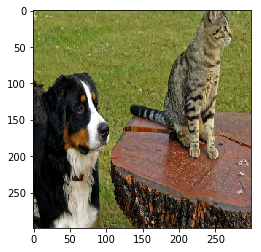

In [9]:
images = transform_img_fn(['dogs.jpg'])
# I'm dividing by 2 and adding 0.5 because of how this Inception represents images
plt.imshow(images[0] / 2 + 0.5)
preds = predict_fn(images)
for x in preds.argsort()[0][-5:]:
    print x, names[x], preds[0,x]

In [10]:
image = images[0]

In [11]:
## Now let's get an explanation

In [12]:
from lime import lime_image
import time

In [13]:
explainer = lime_image.LimeImageExplainer()

hide_color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels. Here, we set it to 0 (in the representation used by inception model, 0 means gray)

In [14]:
tmp = time.time()
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(image, predict_fn, top_labels=5, hide_color=0, num_samples=1000)
print time.time() - tmp

440.970395088


Image classifiers are a bit slow. Notice that an explanation in my macbookpro took 7.33 minutes

### Now let's see the explanation for the top class (Bernese mountain dog)

We can see the top 5 superpixels that are most positive towards the class with the rest of the image hidden

In [15]:
from skimage.segmentation import mark_boundaries

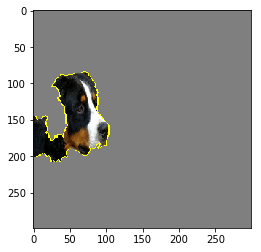

In [16]:
temp, mask = explanation.get_image_and_mask(240, positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

Or with the rest of the image present:

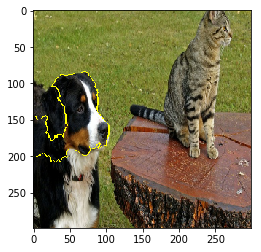

In [17]:
temp, mask = explanation.get_image_and_mask(240, positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))


We can also see the 'pros and cons' (pros in green, cons in red)

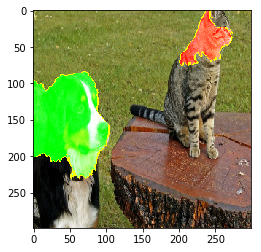

In [18]:
temp, mask = explanation.get_image_and_mask(240, positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))


Or the pros and cons that have weight at least 0.1

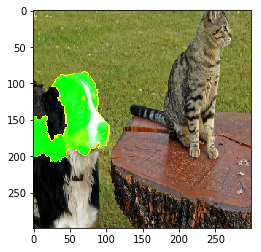

In [19]:
temp, mask = explanation.get_image_and_mask(240, positive_only=False, num_features=1000, hide_rest=False, min_weight=0.1)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

### Let's see the explanation for Egyptian cat 

Most positive towards egyptian cat:

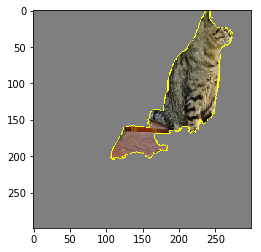

In [20]:
temp, mask = explanation.get_image_and_mask(286, positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

Pros and cons:

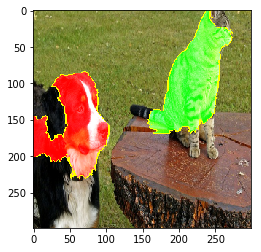

In [21]:
temp, mask = explanation.get_image_and_mask(286, positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
